In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
videos_folder = "https://drive.google.com/drive/folders/1Hjmu0UmxXlWnZyLqvtzCdfZrOtNcl4_k?usp=sharing"

Mounted at /content/gdrive


In [ ]:
def calculate_warp_matrix(parameters):
  warp_matrix = np.array([[1 + parameters[0, 0], parameters[0, 2], parameters[0, 4]],
    [parameters[0, 1], 1 + parameters[0, 3], parameters[0, 5]]
  ])
  return warp_matrix

In [ ]:
def apply_warp(image, warp_matrix, template_points):
  n = template_points.shape[0]
  new_points = np.empty([2, n])
  new_points = np.matmul(warp_matrix, template_points.T)
  new_points = new_points.T
  new_intensities = np.empty([n, 1])
  new_points[:, 0][new_points[:, 0].astype(int) > image.shape[1] - 1] = image.shape[1] - 1
  new_points[:, 1][new_points[:, 1].astype(int) > image.shape[0] - 1] = image.shape[0] - 1
  new_intensities[:, 0] = image[new_points[:, 1].astype(int), new_points[:, 0].astype(int)]
  return new_points, new_intensities

In [ ]:
def apply_gradient_warp(gradient_x, gradient_y, warped_points):
  n = warped_points.shape[0]
  grad_x_intensities = np.empty([n, 1])
  grad_y_intensities = np.empty([n, 1])
  grad_x_intensities[:, 0] = gradient_x[warped_points[:, 1].astype(int), warped_points[:, 0].astype(int)]
  grad_y_intensities[:, 0] = gradient_y[warped_points[:, 1].astype(int), warped_points[:, 0].astype(int)]
  return grad_x_intensities, grad_y_intensities

In [ ]:
def calculate_delta_p(error, warped_dx, warped_dy, template_points):
  img1 = warped_dx[:, 0] * [template_points[:, 0]]
  img2 = warped_dx[:, 0] * [template_points[:, 1]]
  img3 = warped_dy[:, 0] * [template_points[:, 0]]
  img4 = warped_dy[:, 0] * [template_points[:, 1]]
  dIW = np.hstack((img1.T, img3.T, img2.T, img4.T, warped_dx, warped_dy))
  sum_p = np.matmul(dIW.T, error)
  sum_hess = np.matmul(dIW.T, dIW)
  sum_p = np.matmul(np.linalg.pinv(sum_hess), sum_p)
  return sum_p

In [ ]:
def run_tracker(template_points, template_intensity, image, initial_p, start_point, end_point, threshold=1e-4, max_iterations=150):
  iteration = 0
  change_p = 100
  gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  safe_w, safe_p = calculate_warp_matrix(initial_p), initial_p
  while change_p > threshold and iteration < max_iterations:
    W = calculate_warp_matrix(initial_p)
    IW_points, IW_intensity = apply_warp(image, W, template_points)
    error = template_intensity - IW_intensity
    IW_dx, IW_dy = apply_gradient_warp(gradient_x, gradient_y, IW_points)
    delta_p = calculate_delta_p(error, IW_dx, IW_dy, template_points)
    change_p = np.linalg.norm(delta_p)
    initial_p += delta_p.T
    new_start = np.array([[start_point[0]], [start_point[1]], [1]])
    new_end = np.array([[end_point[0]], [end_point[1]], [1]])
    transformed_start = np.matmul(W, new_start)
    transformed_end = np.matmul(W, new_end)
    iteration += 1
  if iteration >= max_iterations:
    return safe_w, safe_p
  return W, initial_p

# **Car Part**

In [ ]:
car_path ="/content/car2.npy";
car_video = np.load(car_path)
outputFileName = "Car.mp4"
startingPoint = [47, 105]
endPoint = [158, 162]
output = np.zeros((car_video.shape[2], car_video.shape[0], car_video.shape[1], 3))


In [ ]:
cv2.imwrite("Frame.png", car_video[:, :, 0])
frame1 = cv2.imread("Frame.png", 0)
h1 = abs(startingPoint[1] - endPoint[1])
w1 = abs(startingPoint[0] - endPoint[0])
frame1Points = np.empty([h1 * w1, 3])
n = 0

In [ ]:
for i in range(startingPoint[0], endPoint[0]):
  for j in range(startingPoint[1], endPoint[1]):
    frame1Points[n, 0] = i
    frame1Points[n, 1] = j
    frame1Points[n, 2] = 1
    n += 1
frame1Intensities = np.empty([h1 * w1, 1])
n = 0
for i in frame1Points:
    frame1Intensities[n, 0] = frame1[int(i[1]), int(i[0])]
    n += 1
mean1 = np.mean(frame1)

In [ ]:
p = np.zeros([1, 6], dtype=float)
for i in tqdm(range(car_video.shape[2])):
  cv2.imwrite("Frame.png", car_video[:, :, i])
  frame = cv2.imread("Frame.png", 0)
  mean2 = np.mean(frame)
  frame = frame.astype(float)
  frame = frame * (mean1 / mean2)
  updatedParam, p = run_tracker(frame1Points, frame1Intensities, frame, p, startingPoint, endPoint)
  # Updating boundary points
  newstartPoint = np.array([[startingPoint[0]], [startingPoint[1]], [1]])
  newendPoint = np.array([[endPoint[0]], [endPoint[1]], [1]])
  topLeft = np.matmul(updatedParam, newstartPoint).astype(int)
  botRight = np.matmul(updatedParam, newendPoint).astype(int)
  topRight = np.array([[startingPoint[0]], [endPoint[1]], [1]])
  botLeft = np.array([[endPoint[0]], [startingPoint[1]], [1]])
  topRight = np.matmul(updatedParam, topRight).astype(int)
  botLeft = np.matmul(updatedParam, botLeft).astype(int)
  # Draw bounding box
  outFrame = cv2.imread("Frame.png")
  start = (min(int(topLeft[0]), int(topRight[0])), min(int(topLeft[1]), int(botLeft[1])))
  end = (max(int(botLeft[0]), int(botRight[0])), max(int(topRight[1]), int(botRight[1])))
  outFrame = cv2.rectangle(outFrame, start, end, (0, 0, 0), 1)
  output[i] = outFrame
output = np.uint8(output)

100%|██████████| 415/415 [01:22<00:00,  5.02it/s]


In [ ]:
height, width, layers = output[0].shape
size = (width,height)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter(outputFileName, fourcc, 15, size)
for i in range(len(output)):
  writer.write(output[i])
writer.release()

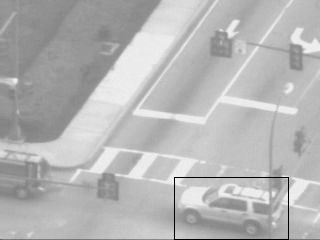

In [ ]:
cv2.imwrite("Frame.png", output[100])
frame = cv2.imread("Frame.png")
cv2_imshow(frame)

# **Helicopter Part**

In [ ]:
file_id = '1CHYZI71Zcezj8tTXRMYF3dSDyY17ny_3'
download_link = f'https://drive.google.com/uc?id={file_id}'
output_path = 'landing.npy'
!gdown $download_link -O $output_path
helicopter_path='/content/gdrive/MyDrive/landing.npy'
helicopter_vedio=np.load(helicopter_path)
outputFileName = "Landing.mp4"
startingPoint = [430,75]
endPoint = [570,135]
output = np.zeros((helicopter_vedio.shape[2], helicopter_vedio.shape[0], helicopter_vedio.shape[1], 3))

In [ ]:
cv2.imwrite("Frame.png", helicopter_vedio[:, :, 0])
frame1 = cv2.imread("Frame.png", 0)
h1 = abs(startingPoint[1] - endPoint[1])
w1 = abs(startingPoint[0] - endPoint[0])
frame1Points = np.empty([h1 * w1, 3])
n = 0

In [ ]:
for i in range(startingPoint[0], endPoint[0]):
  for j in range(startingPoint[1], endPoint[1]):
    frame1Points[n, 0] = i
    frame1Points[n, 1] = j
    frame1Points[n, 2] = 1
    n += 1
frame1Intensities = np.empty([h1 * w1, 1])
n = 0
for i in frame1Points:
    frame1Intensities[n, 0] = frame1[int(i[1]), int(i[0])]
    n += 1
mean1 = np.mean(frame1)

In [ ]:
p = np.zeros([1, 6], dtype=float)
for i in tqdm(range(helicopter_vedio.shape[2])):
  cv2.imwrite("Frame.png", helicopter_vedio[:, :, i])
  frame = cv2.imread("Frame.png", 0)
  mean = np.mean(frame)
  frame = frame.astype(float)
  frame = frame * (mean1 / mean)
  updatedParam, p = run_tracker(frame1Points, frame1Intensities, frame, p, startingPoint, endPoint)
  # Updating boundary points
  newstartPoint = np.array([[startingPoint[0]], [startingPoint[1]], [1]])
  newendPoint = np.array([[endPoint[0]], [endPoint[1]], [1]])
  topLeft = np.matmul(updatedParam, newstartPoint).astype(int)
  botRight = np.matmul(updatedParam, newendPoint).astype(int)
  topRight = np.array([[startingPoint[0]], [endPoint[1]], [1]])
  botLeft = np.array([[endPoint[0]], [startingPoint[1]], [1]])
  topRight = np.matmul(updatedParam, topRight).astype(int)
  botLeft = np.matmul(updatedParam, botLeft).astype(int)
  # Draw bounding box
  outFrame = cv2.imread("Frame.png")
  start = (min(int(topLeft[0]), int(topRight[0])), min(int(topLeft[1]), int(botLeft[1])))
  end = (max(int(botLeft[0]), int(botRight[0])), max(int(topRight[1]), int(botRight[1])))
  outFrame = cv2.rectangle(outFrame, start, end, (0, 0, 0), 1)
  output[i] = outFrame
output = np.uint8(output)

100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


In [ ]:
height, width, layers = output[0].shape
size = (width,height)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter(outputFileName, fourcc, 15, size)
for i in range(len(output)):
    writer.write(output[i])
writer.release()

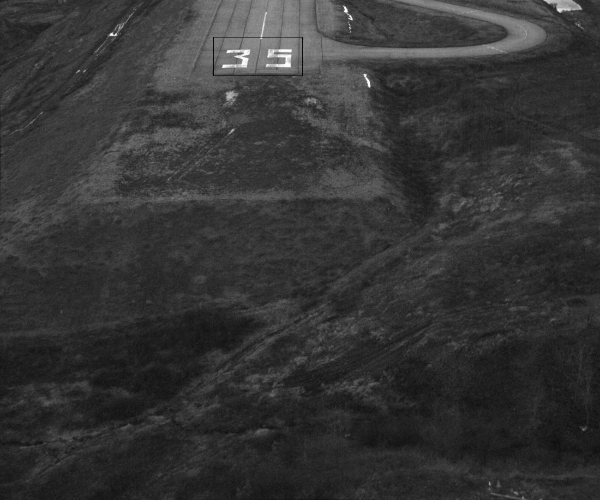

In [ ]:
cv2.imwrite("Frame.png", cv2.resize(output[15], (600, 500)) )
frame = cv2.imread("Frame.png")
cv2_imshow(frame)